<a href="https://colab.research.google.com/github/doubojv/Titanic/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report


In [43]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
df = df.drop(columns=['PassengerId', 'Name', 'Ticket'])

In [45]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'Q': 1, 'C': 2})

In [46]:
df.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
886,0,2,0,27.0,0,0,13.00,NaN,0.0
887,1,1,1,19.0,0,0,30.00,B42,0.0
888,0,3,1,NaN,1,2,23.45,NaN,0.0
889,1,1,0,26.0,0,0,30.00,C148,2.0
890,0,3,0,32.0,0,0,7.75,NaN,1.0


In [47]:

# Mapeamento das cabines
mapeamento = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7
}

def mapear_para_inteiro(valor):
    if isinstance(valor, str) and len(valor) > 0:
        char = valor[0]
        return mapeamento.get(char, 0)
    else:
        return 0

# Aplicar o mapeamento na coluna 'Cabin'
df['Cabin'] = df['Cabin'].apply(mapear_para_inteiro)

print(df)

     Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Cabin  Embarked
0           0       3    0  22.0      1      0   7.2500      0       0.0
1           1       1    1  38.0      1      0  71.2833      3       2.0
2           1       3    1  26.0      0      0   7.9250      0       0.0
3           1       1    1  35.0      1      0  53.1000      3       0.0
4           0       3    0  35.0      0      0   8.0500      0       0.0
..        ...     ...  ...   ...    ...    ...      ...    ...       ...
886         0       2    0  27.0      0      0  13.0000      0       0.0
887         1       1    1  19.0      0      0  30.0000      2       0.0
888         0       3    1   NaN      1      2  23.4500      0       0.0
889         1       1    0  26.0      0      0  30.0000      3       2.0
890         0       3    0  32.0      0      0   7.7500      0       1.0

[891 rows x 9 columns]


In [48]:
df_age = df['Age']


def mapear_para_faixa_etaria(idade):
    if idade < 10:
        return 1
    elif 10 <= idade <= 20:
        return 2
    elif 20 <= idade <= 30:
        return 3
    elif 30 <= idade <= 40:
        return 4
    elif 40 <= idade <= 50:
        return 5
    elif 50 <= idade <= 60:
        return 6
    elif 60 <= idade <= 70:
        return 7
    elif 70 <= idade <= 80:
        return 8
    elif 80 <= idade <= 90:
        return 9
    else:
        return 0

df_age = df_age.apply(mapear_para_faixa_etaria)

df_age

0      3
1      4
2      3
3      4
4      4
      ..
886    3
887    2
888    0
889    3
890    4
Name: Age, Length: 891, dtype: int64

In [49]:
df["Age"].fillna(0, inplace=True)

mean_embarked = df["Embarked"].mean()
df["Embarked"].fillna(mean_embarked, inplace=True)

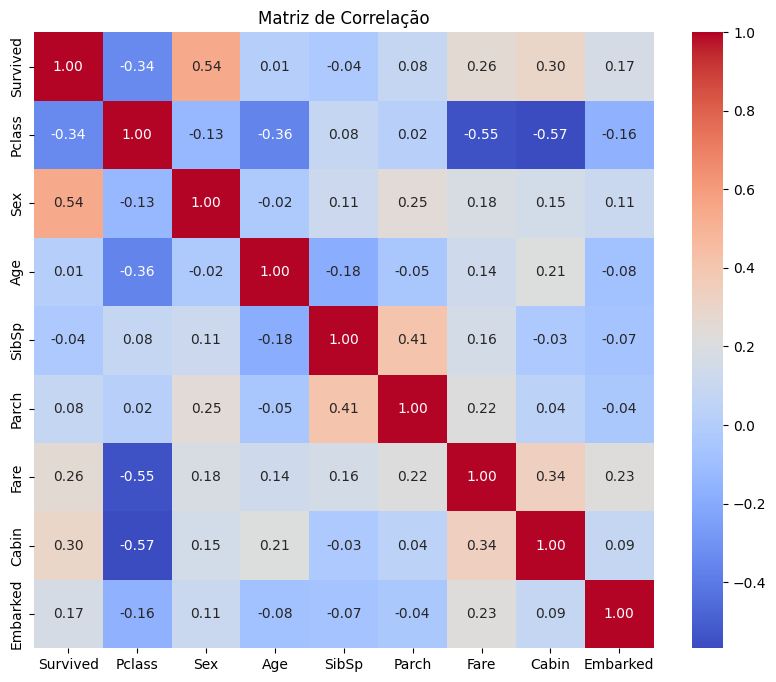

In [52]:
# Calcular a matriz de correlação
corr = df.corr()

# Plotar a matriz de correlação usando um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

In [62]:
X = df.loc[:, df.columns != 'Survived'].values
y = df['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
smote = SMOTE(sampling_strategy='auto', k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [65]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [68]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(X_train.shape[1], 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.sigmoid(self.output(x))
        return x

In [70]:
model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    predicted = model(X_test_tensor)
    predicted = (predicted > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy.item():.4f}')

Epoch [10/100], Loss: 0.5810
Epoch [20/100], Loss: 0.5726
Epoch [30/100], Loss: 0.5639
Epoch [40/100], Loss: 0.5550
Epoch [50/100], Loss: 0.5462
Epoch [60/100], Loss: 0.5373
Epoch [70/100], Loss: 0.5285
Epoch [80/100], Loss: 0.5199
Epoch [90/100], Loss: 0.5108
Epoch [100/100], Loss: 0.5008
Accuracy: 0.7989


In [77]:
y_test_numpy = y_test_tensor.numpy()
predicted_numpy = predicted.numpy()

print(classification_report(y_test_numpy, predicted_numpy))

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82       105
         1.0       0.73      0.82      0.77        74

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.80       179
weighted avg       0.81      0.80      0.80       179



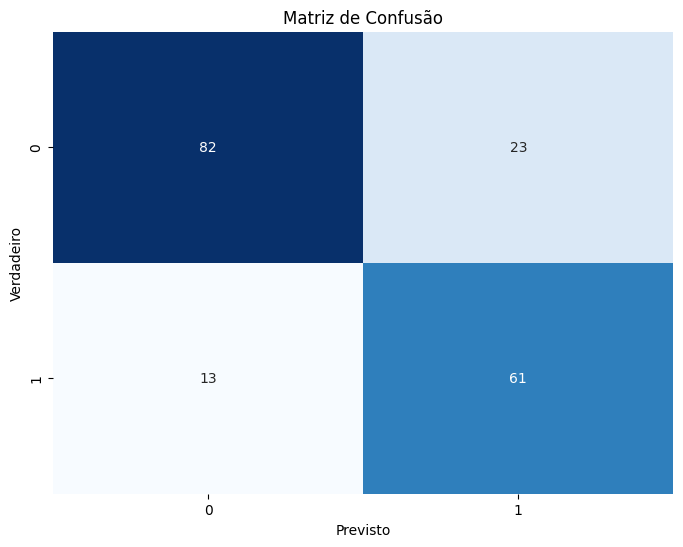

In [81]:
confusion = confusion_matrix(y_test_numpy, predicted_numpy)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()